In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.nn import MSELoss, L1Loss, CrossEntropyLoss
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pandas as pd
from drive.MyDrive.cbin import CBINorm2d #source https://github.com/Xiaoming-Yu/SingleGAN/blob/master/models/cbin.py
from torchsummary import summary
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

cpu


In [ ]:
!unrar x /content/drive/MyDrive/cat2dog.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/cat2dog.rar

Extracting  one_hot_cat2dog.csv                                            0%  OK 
Creating    images                                                    OK
Extracting  images/0.jpg                                                   0%  OK 
Extracting  images/1.jpg                                                   0%  OK 
Extracting  images/10.jpg                                                  0%  OK 
Extracting  images/100.jpg                                                 0%  OK 
Extracting  images/1000.jpg                                                0%  OK 
Extracting  images/1001.jpg                                                0%  OK 
Extracting  images/1002.jpg                                                0%  OK 
Extracting  images/1003.jpg                                           

In [ ]:
import random


class Poster(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file, delimiter=',')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.df.iloc[idx, 0]))
        image = PIL.Image.open(img_name + '.jpg')
        if self.transform:
            image = self.transform(image)
        label = self.df.iloc[idx, 1:].tolist()
        label = torch.FloatTensor(label)

        ind2 = random.randint(0,self.__len__()-1)
        img_name2 = os.path.join(self.root_dir,
                                str(self.df.iloc[ind2, 0]))
        image2 = PIL.Image.open(img_name2 + '.jpg')
        if self.transform:
            image2 = self.transform(image2)
        label2 = self.df.iloc[ind2, 1:].tolist()
        label2 = torch.FloatTensor(label2)

        return [image, label, image2, label2]
    
tensor_transform = transforms.ToTensor()
dataset = Poster(root_dir = r"/content/images",
                         csv_file = r"/content/one_hot_cat2dog.csv",
                         transform = tensor_transform)

print("label length =",len(dataset[0][1]))
train_size = 2000
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
print('train_set=',len(train_set), 'test_set=', len(test_set))

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                     batch_size = batch_size,
                                     shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                     batch_size = batch_size,
                                     shuffle = True)

label length = 2
train_set= 2000 test_set= 235


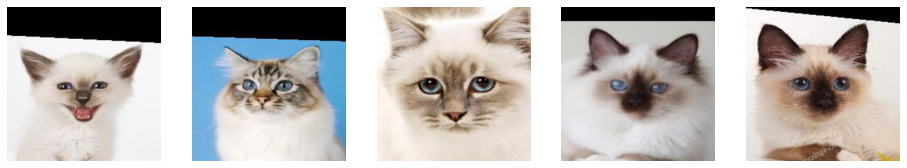

In [ ]:
fig = plt.figure(figsize=(16, 12))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    sample = dataset[i][0]
    sample = sample.swapaxes(0, 1)
    sample = sample.swapaxes(1, 2)
    ax.axis('off')
    plt.imshow(sample)

In [ ]:
y_length = 2 #labels length vector
Z_length = 8 #style length vector
y_Z_length = y_length + Z_length


class CD_Res_block(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.CBIN_1 = CBINorm2d(num_features=in_channels, num_con=y_length)
        self.CBIN_2 = CBINorm2d(num_features=out_channels, num_con=y_length)
        self.l1 = torch.nn.Conv2d(in_channels, out_channels, 3, 1, 0)
        self.l2 = torch.nn.Conv2d(out_channels, out_channels, 1, 1, 0)
        self.l3 = torch.nn.Conv2d(in_channels, out_channels, 3, 1, 0)

    def forward(self, x, y):
        x_tmp = self.CBIN_1(x, y)
        x_tmp = torch.nn.ReLU()(x_tmp)
        x_tmp = self.l1(x_tmp)
        x_tmp = self.CBIN_2(x_tmp, y)
        x_tmp = torch.nn.ReLU()(x_tmp)
        x_tmp = torch.nn.AvgPool2d(2,2)(x_tmp)
        x_tmp = self.l2(x_tmp)
        x = self.l3(x)
        x = torch.nn.AvgPool2d(2,2)(x)
        x = x + x_tmp
        return x


class Style_Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Conv2d(3, 64, 4, 2, 1)
        self.CD_Res_block_128 = CD_Res_block(64, 128)
        self.CD_Res_block_256_1 = CD_Res_block(128, 256)
        self.CD_Res_block_256_2 = CD_Res_block(256, 256)
        self.CBIN_256 = CBINorm2d(num_features=256, num_con=y_length)
        self.l3 = torch.nn.Linear(256, Z_length)

    def forward(self, x, y):
        x = self.l1(x)
        x = self.CD_Res_block_128(x, y)
        x = self.CD_Res_block_256_1(x, y)
        x = self.CD_Res_block_256_2(x, y)
        x = self.CBIN_256(x, y)
        x = torch.nn.ReLU()(x)
        x = x.mean(dim=(-2, -1)) #GAP
        x = self.l3(x)
        return x

class R_Res_block(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Conv2d(256, 256, 3, 1, 1)
        self.l2 = torch.nn.Conv2d(256, 256, 3, 1, 1)

    def forward(self, x):
        x_tmp = self.l1(x)
        x_tmp = torch.nn.InstanceNorm2d(256)(x_tmp)
        x_tmp = torch.nn.ReLU()(x_tmp)
        x_tmp = self.l2(x_tmp)
        x_tmp = torch.nn.InstanceNorm2d(256)(x_tmp)
        x_tmp = torch.nn.ReLU()(x_tmp)
        x = x + x_tmp
        return x

class Content_Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Conv2d(3, 64, 7, 1, 3)
        self.l2 = torch.nn.Conv2d(64, 128, 4, 2, 1)
        self.l3 = torch.nn.Conv2d(128, 256, 4, 2, 1)
        self.R_Res_block1 = R_Res_block()
        self.R_Res_block2 = R_Res_block()
        self.R_Res_block3 = R_Res_block()
        self.R_Res_block4 = R_Res_block()

    def forward(self, x):
        x = self.l1(x)
        x = torch.nn.InstanceNorm2d(64)(x)
        x = torch.nn.ReLU()(x)
        x = self.l2(x)
        x = torch.nn.InstanceNorm2d(128)(x)
        x = torch.nn.ReLU()(x)
        x = self.l3(x)
        x = torch.nn.InstanceNorm2d(256)(x)
        x = torch.nn.ReLU()(x)
        x = self.R_Res_block1(x)
        x = self.R_Res_block2(x)
        x = self.R_Res_block3(x)
        x = self.R_Res_block4(x)
        return x


class C_Res_block(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.CBIN_256_1 = CBINorm2d(num_features=256, num_con=y_Z_length)
        self.CBIN_256_2 = CBINorm2d(num_features=256, num_con=y_Z_length)
        self.l1 = torch.nn.Conv2d(256, 256, 3, 1, 1)
        self.l2 = torch.nn.Conv2d(256, 256, 3, 1, 1)
    def forward(self, x, y_Z):
        x_tmp = self.CBIN_256_1(x, y_Z)
        x_tmp = torch.nn.ReLU()(x_tmp)
        x_tmp = self.l1(x_tmp)
        x_tmp = self.CBIN_256_2(x_tmp, y_Z)
        x_tmp = torch.nn.ReLU()(x_tmp)
        x_tmp = self.l2(x_tmp)
        x = x + x_tmp
        return x


class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.CBIN_256_3 = CBINorm2d(num_features=256, num_con=y_Z_length)
        self.CBIN_256_4 = CBINorm2d(num_features=256, num_con=y_Z_length)
        self.CBIN_128 = CBINorm2d(num_features=128, num_con=y_Z_length)
        self.CBIN_64 = CBINorm2d(num_features=64, num_con=y_Z_length)
        self.l3 = torch.nn.Conv2d(256, 256, 3, 1, 1)
        self.l4 = torch.nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.l5 = torch.nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.l6 = torch.nn.Conv2d(64, 3, 7, 1, 3)
        self.C_Res_block1 = C_Res_block()
        self.C_Res_block2 = C_Res_block()
        self.C_Res_block3 = C_Res_block()
        self.C_Res_block4 = C_Res_block()
        self.C_Res_block5 = C_Res_block()

    def forward(self, x, y, Z):
        y_Z = torch.cat((y,Z),1)
        x = self.l3(x)
        x = self.CBIN_256_3(x, y_Z)
        x = torch.nn.ReLU()(x)
        x = self.C_Res_block1(x, y_Z)
        x = self.C_Res_block2(x, y_Z)
        x = self.C_Res_block3(x, y_Z)
        x = self.C_Res_block4(x, y_Z)
        x = self.C_Res_block5(x, y_Z)
        x = self.CBIN_256_4(x, y_Z)
        x = torch.nn.ReLU()(x)
        x = self.l4(x)
        x = self.CBIN_128(x, y_Z)
        x = torch.nn.ReLU()(x)
        x = self.l5(x)
        x = self.CBIN_64(x, y_Z)
        x = torch.nn.ReLU()(x)
        x = self.l6(x)
        x = torch.nn.Sigmoid()(x)
        return x
    
    
class Combined(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.Style_Encoder = Style_Encoder()
        self.Content_Encoder = Content_Encoder()
        self.Generator = Generator()

    def forward(self, x, y):
        Z = self.Style_Encoder(x, y)
        x = self.Content_Encoder(x)
        x = self.Generator(x, y, Z)
        return x
    
    def generate_image(self, x, y, Z=None):
        if Z == None:
          Z = torch.normal(0, 1, size=(batch_size, Z_length))
        Z = Z.to(device)
        x = self.Content_Encoder(x)
        x = self.Generator(x, y, Z)
        return x    

    def style_transfer(self, content_image, y, style_img):
        Z = self.Style_Encoder(style_img, y)
        content_image = self.Content_Encoder(content_image)
        content_image = self.Generator(content_image, y, Z)
        return content_image 
    
combined = Combined().to(device)
combined_optimizer = torch.optim.Adam(combined.parameters(),
                             lr = 0.0002)

combined_scheduler = StepLR(combined_optimizer, step_size=1, gamma=0.000004)


class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l0 = torch.nn.Conv2d(3, 32, 4, 2, 1)
        self.l1 = torch.nn.Conv2d(32, 64, 4, 2, 1)
        self.l2 = torch.nn.Conv2d(64, 128, 4, 2, 1)
        self.l3 = torch.nn.Conv2d(128, 256, 4, 2, 1)
        self.l4 = torch.nn.Conv2d(256, 512, 4, 2, 1)
        self.l5 = torch.nn.Conv2d(512, y_length, 1, 1, 1)
        self.l6 = torch.nn.Linear(y_length, 1)
        self.l7 = torch.nn.Embedding(num_embeddings=3, embedding_dim=1, sparse=False)
        self.l8 = torch.nn.Conv2d(512, 1024, 4, 2, 1)
        self.l9 = torch.nn.Conv2d(1024, y_length, 4, 1, 0)
        self.l10 = torch.nn.Linear(y_length*5*5,y_length)

    def forward(self, x, y):
        x = self.l0(x)#add
        x = self.l1(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.l2(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.l3(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.l4(x)
        x = torch.nn.LeakyReLU()(x)
        h = self.l5(x)
        h = h.mean(dim=(-2, -1))#GAP
        d = self.l6(h)
        dis = self.l7(y.int()).view(h.size()) @ h.T + d
        # dis = y @ h.T + d
        x = self.l8(x)
        cls = self.l9(x)
        #cls = torch.flatten(cls,1)#add
        #cls = self.l10(cls)
        #cls = torch.nn.Softmax(dim=1)(cls)
        cls = cls.view(-1,y_length)  
        return dis, cls
    
discriminator = Discriminator().to(device)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),
                             lr = 0.0002)

discriminator_scheduler = StepLR(discriminator_optimizer, step_size=1, gamma=0.000004)

In [ ]:
summary(combined, [(3, 256, 256), (y_length,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Linear-2                   [-1, 64]             256
              Tanh-3                   [-1, 64]               0
         CBINorm2d-4         [-1, 64, 128, 128]               0
            Conv2d-5        [-1, 128, 126, 126]          73,856
            Linear-6                  [-1, 128]             512
              Tanh-7                  [-1, 128]               0
         CBINorm2d-8        [-1, 128, 126, 126]               0
            Conv2d-9          [-1, 128, 63, 63]          16,512
           Conv2d-10        [-1, 128, 126, 126]          73,856
     CD_Res_block-11          [-1, 128, 63, 63]               0
           Linear-12                  [-1, 128]             512
             Tanh-13                  [-1, 128]               0
        CBINorm2d-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


TypeError: ignored

In [ ]:
summary(discriminator, [(3, 256, 256), (y_length,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           1,568
            Conv2d-2           [-1, 64, 64, 64]          32,832
            Conv2d-3          [-1, 128, 32, 32]         131,200
            Conv2d-4          [-1, 256, 16, 16]         524,544
            Conv2d-5            [-1, 512, 8, 8]       2,097,664
            Conv2d-6            [-1, 3, 10, 10]           1,539
            Linear-7                    [-1, 1]               4
         Embedding-8                 [-1, 3, 1]               3
            Conv2d-9           [-1, 1024, 4, 4]       8,389,632
           Conv2d-10              [-1, 3, 1, 1]          49,155


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


TypeError: ignored

In [ ]:
class AdversarialLoss(torch.nn.Module):

    def __init__(self):
        super(AdversarialLoss, self).__init__()
        self.mse = MSELoss(reduction='mean')

    def forward(self, D_real, D_fake):
        G_loss = self.mse(D_fake, torch.ones_like(D_fake))/2
        D_loss_real = self.mse(D_real, torch.ones_like(D_real))/2
        D_loss_fake = self.mse(D_fake, torch.zeros_like(D_fake))/2
        D_loss = D_loss_real + D_loss_fake
        return G_loss, D_loss

class DomainClassificationLoss(torch.nn.Module):

    def __init__(self):
        super(DomainClassificationLoss, self).__init__()
        self.bce = CrossEntropyLoss(reduction='mean')

    def forward(self, D_out, y):
        return self.bce(D_out, torch.argmax(y, dim=1))
        # return torch.sum(-torch.log(D_out))


class CycleConsistencyLoss(torch.nn.Module):

    def __init__(self):
        super(CycleConsistencyLoss, self).__init__()
        self.l1 = L1Loss(reduction='mean')

    def forward(self, x, x_rec):
        return self.l1(x, x_rec)

class BidirectionalReconstructionLoss(torch.nn.Module):

    def __init__(self):
        super(BidirectionalReconstructionLoss, self).__init__()
        self.l1 = L1Loss(reduction='mean')

    def forward(self, x, x_rec, z, z_rec, c, c_rec):
        L_img_rec = self.l1(x, x_rec)
        L_latent_rec = self.l1(z, z_rec) + self.l1(c, c_rec)
        return L_img_rec, L_latent_rec
    
def draw(combined):
    with torch.no_grad():
        fig = plt.figure(figsize=(16, 12))
        combined.eval()
        for i, (image,y, image2, y2) in enumerate(test_loader):
            sample = image[0].numpy()
            sample = sample.swapaxes(0, 1)
            sample = sample.swapaxes(1, 2)
            style = image[1].numpy()
            style = style.swapaxes(0, 1)
            style = style.swapaxes(1, 2)
            ax = plt.subplot(5, 3, 1 + i*3)
            ax.axis('off')
            plt.imshow(sample)
            image = image.to(device)
            image_style = image.clone()
            image_style[0] = image_style[1]
            image_style = image_style.to(device)
            y[0] = y[1]
            y = y.to(device)
            pred = combined.style_transfer(image,y, image_style)
            # style = style.cpu()
            # image = image.cpu()
            pred = pred.cpu()
            ax = plt.subplot(5, 3, 2 + i*3)
            ax.axis('off')
            plt.imshow(style)
            sample = pred[0].numpy()
            sample = sample.swapaxes(0, 1)
            sample = sample.swapaxes(1, 2)
            ax = plt.subplot(5, 3, 3 + i*3)
            ax.axis('off')
            plt.imshow(sample)
            if i >= 4:
              plt.show(block = False)
              plt.close()
              break

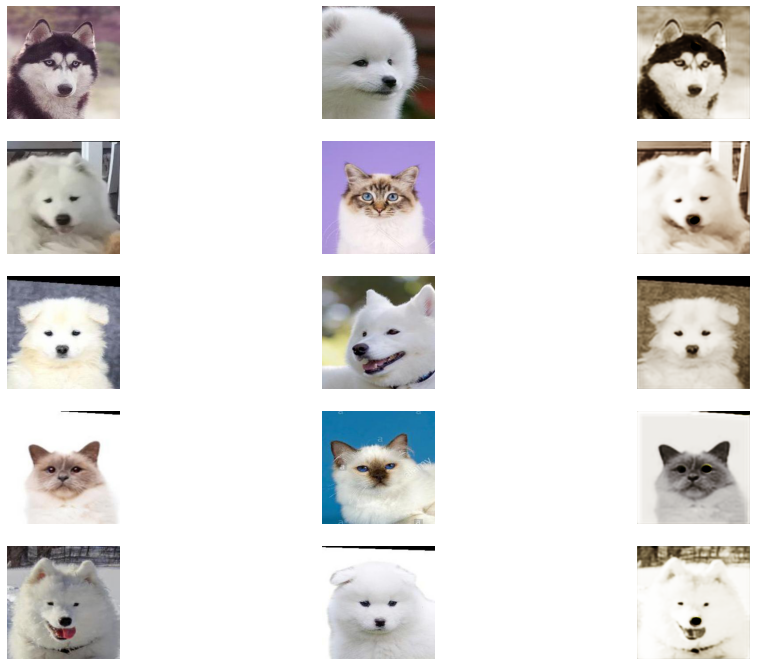

In [ ]:
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/discriminator_animals_paper', map_location=device))
combined.load_state_dict(torch.load('/content/drive/MyDrive/combined_animals_paper', map_location=device))
draw(combined)

In [ ]:
Es = combined.Style_Encoder
Ec = combined.Content_Encoder
G = combined.Generator
D = discriminator
train_size, test_size = len(train_loader.dataset), len(test_loader.dataset)

''' decay should be The initial learning rate decays
to zero linearly in the remaining n epochs, where n is set to 50
unless otherwise noted
'''
# loss intialization
adversarial_loss = AdversarialLoss()
domain_classification_loss = DomainClassificationLoss()
cycle_loss = CycleConsistencyLoss()
reconstruction_loss = BidirectionalReconstructionLoss()

N = y_length
LAMBDA_CLS = 1
LAMBDA_CYC = 10
LAMBDA_IMG_REC = 10
LAMBDA_LATENT_REC = 1

torch.autograd.set_detect_anomaly(True)

for epoch in range(100):
    combined.train()
    discriminator.train()
    train_loss = 0
  # loop = tqdm(train_loader, leave=True)
    for i, (x, y, x2, y2) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        x2, y2 = x2.to(device), y2.to(device)
      # Obtain target domain labels and style vectors randomly.
        # y_fake = np.eye(N)[np.random.choice(N, batch_size)]#0ne hot
        #y_fake = np.random.choice([0, 1], size=(batch_size, N), p=[21./N, 4./N])
        #inds = np.where(np.array(np.sum(y_fake, axis=1)) == 0)[0]
        #y_fake[inds] = np.eye(N)[np.random.choice(N, len(inds))]#multiple 1
        # y_fake = torch.from_numpy(y_fake).float()
        # y_fake = y_fake.to(device)
      # y = F.one_hot(y, num_classes=N)
        z = np.random.normal(size=(batch_size, Z_length))
        z = torch.from_numpy(z).float()
        z = z.to(device)
      # Extract the content and style feature
        c, s = Ec(x), Es(x, y)
      # Extract the content and style feature 2
        c2, s2 = Ec(x2), Es(x2, y2)
      # Generate fake image
        fake_image = G(c, y2, z)
      # generator and discriminator forward   
        D_real_IP, D_real_cls = D(x2, y2)
        D_fake_IP, D_fake_cls = D(fake_image, y2)
        
        

      # Update Discriminator
      # Adversarial loss
        G_adv_loss, D_adv_loss = adversarial_loss(D_real_IP, D_fake_IP.detach())
      # Domain Classification loss
        D_domain_loss = domain_classification_loss(D_real_cls, y2)
      # Discriminator loss
        LD = D_adv_loss + LAMBDA_CLS * D_domain_loss
        
        discriminator_optimizer.zero_grad()
        LD.backward(retain_graph=True)
        discriminator_optimizer.step()

      # Update generator and encoder
      # Reconstruction of images, content and style features
        x_rec, c_rec, z_rec = G(c, y, s), Ec(fake_image), Es(fake_image, y2) 
      # generator and discriminator forward (Reconstruction)
        # D_fake_IP, D_fake_cls = D(x_rec, y)
      # Adversarial loss
        G_adv_loss, D_adv_loss = adversarial_loss(D_real_IP, D_fake_IP.detach())
      # Domain Classification loss
        D_domain_loss = domain_classification_loss(D_fake_cls.detach(), y2)
      # Cycle Consistency Loss
      # Generator with encoder style input
        x_cycle = G(c_rec, y, s)
        cyc_loss = cycle_loss(x, x_cycle)
      # Bidirectional Reconstruction Loss
        L_img_rec, L_latent_rec = reconstruction_loss(x, x_rec, z, z_rec, c, c_rec)
      # Generator&Encoders Loss
        LGE = G_adv_loss + LAMBDA_CLS * D_domain_loss + LAMBDA_CYC * cyc_loss + LAMBDA_IMG_REC * L_img_rec + LAMBDA_LATENT_REC * L_latent_rec
        
        combined_optimizer.zero_grad()
        LGE.backward(retain_graph=True)
        combined_optimizer.step()
        
        loss = LD + LGE
        train_loss += loss.item()
        loss = train_loss / (i+1)
        print(f"\r Epoch {epoch+1}, batch [{i+1:>5d}/{int(np.ceil(train_size/batch_size)):>5d}]\t loss: {loss:>7f}", end="")
        
        if (i+1) % 200 == 0:
              torch.save(discriminator.state_dict(), '/content/drive/MyDrive/discriminator_animals_paper')       
              torch.save(combined.state_dict(), '/content/drive/MyDrive/combined_animals_paper')
              draw(combined)
                  
    with torch.no_grad():
        combined.eval()
        discriminator.eval()
        test_loss = 0
        LD_loss = 0
        LGE_loss = 0
        for i, (x, y, x2, y2) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            x2, y2 = x2.to(device), y2.to(device)
          # Obtain target domain labels and style vectors randomly.
            # y_fake = np.eye(N)[np.random.choice(N, batch_size)]#0ne hot
            #y_fake = np.random.choice([0, 1], size=(batch_size, N), p=[21./N, 4./N])
            #inds = np.where(np.array(np.sum(y_fake, axis=1)) == 0)[0]
            #y_fake[inds] = np.eye(N)[np.random.choice(N, len(inds))]#multiple 1
            # y_fake = torch.from_numpy(y_fake).float()
            # y_fake = y_fake.to(device)
          # y = F.one_hot(y, num_classes=N)
            z = np.random.normal(size=(batch_size, Z_length))
            z = torch.from_numpy(z).float()
            z = z.to(device)
          # Extract the content and style feature
            c, s = Ec(x), Es(x, y)
          # Extract the content and style feature 2
            c2, s2 = Ec(x2), Es(x2, y2)
          # Generate fake image
            fake_image = G(c, y2, z)
          # generator and discriminator forward
            D_real_IP, D_real_cls = D(x2, y2)
            D_fake_IP, D_fake_cls = D(fake_image, y2)

          # Update Discriminator
          # Adversarial loss
            G_adv_loss, D_adv_loss = adversarial_loss(D_real_IP, D_fake_IP)
          # Domain Classification loss
            D_domain_loss = domain_classification_loss(D_real_cls, y2)
          # Discriminator loss
            LD = D_adv_loss + LAMBDA_CLS * D_domain_loss
            
            discriminator_optimizer.zero_grad()
            LD = Variable(LD.data, requires_grad=True)
            LD.backward(retain_graph=True)
            discriminator_optimizer.step()

          # Update generator and encoder
          # Reconstruction of images, content and style features
            x_rec, c_rec, z_rec = G(c, y, s), Ec(fake_image), Es(fake_image, y2) 
          # generator and discriminator forward (Reconstruction)
            # D_fake_IP, D_fake_cls = D(x_rec, y)
          # Adversarial loss
            G_adv_loss, D_adv_loss = adversarial_loss(D_real_IP, D_fake_IP)
          # Domain Classification loss
            D_domain_loss = domain_classification_loss(D_fake_cls, y2)
          # Cycle Consistency Loss
          # Generator with encoder style input
            x_cycle = G(c_rec, y, s)
            cyc_loss = cycle_loss(x, x_cycle)
          # Bidirectional Reconstruction Loss
            L_img_rec, L_latent_rec = reconstruction_loss(x, x_rec, z, z_rec, c, c_rec)
          # Generator&Encoders Loss
            LGE = G_adv_loss + LAMBDA_CLS * D_domain_loss + LAMBDA_CYC * cyc_loss + LAMBDA_IMG_REC * L_img_rec + LAMBDA_LATENT_REC * L_latent_rec

            combined_optimizer.zero_grad()
            LGE = Variable(LGE, requires_grad=True)
            LGE.backward(retain_graph=True)
            combined_optimizer.step()

            loss = LD + LGE

            LD_loss += LD
            LGE_loss += LGE

            test_loss += loss.item()                
                
        test_loss = test_loss / len(test_loader)
        print(f"\t test loss: {test_loss:>7f}")
    combined_scheduler.step()
    discriminator_scheduler.step()        

KeyboardInterrupt: ignored



```
# Sformatowano jako kod
```

original
animation
horror
romance:

In [ ]:
def draw(combined):
    with torch.no_grad():
        fig = plt.figure(figsize=(16, 12))
        combined.eval()
        for i, (image,y) in enumerate(test_loader):
            sample = image[0].numpy()
            sample = sample.swapaxes(0, 1)
            sample = sample.swapaxes(1, 2)
            ax = plt.subplot(4, 5, i + 1)
            ax.axis('off')
            plt.imshow(sample)
            for cls in range(2):
              image = image.to(device)
              y = np.zeros((batch_size,y_length))
              y[:,cls] = 1
              y = torch.from_numpy(y).float()
              y = y.to(device)
              pred = combined.generate_image(image,y)
              image = image.cpu()
              pred = pred.cpu()
              sample = pred[0].numpy()
              sample = sample.swapaxes(0, 1)
              sample = sample.swapaxes(1, 2)
              ax = plt.subplot(4, 5, (cls+1)*5 + i + 1)
              ax.axis('off')
              plt.imshow(sample)
            if i >= 4:
                plt.show(block = False)
                plt.close()
                break
draw(combined)

ValueError: ignored

<Figure size 1152x864 with 0 Axes>

change style vector:

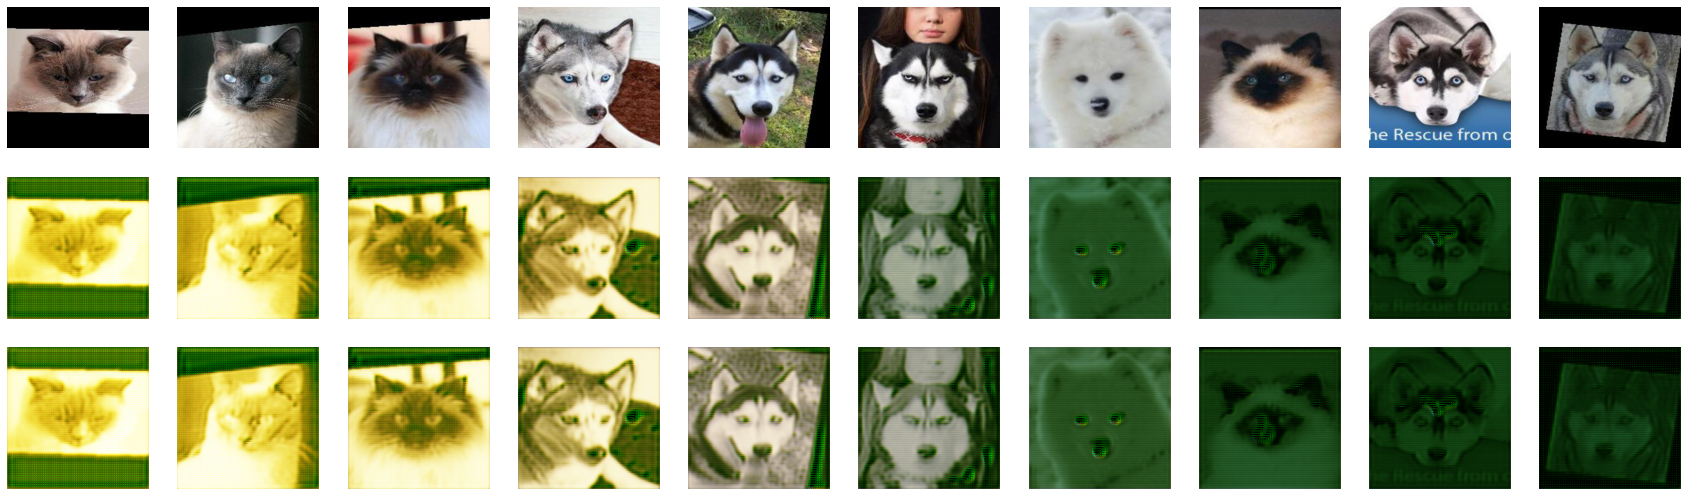

In [ ]:
def draw(z, step):
    with torch.no_grad():
        fig = plt.figure(figsize=(30, 12))
        combined.eval()
        for i, (image,y) in enumerate(test_loader):
            sample = image[0].numpy()
            sample = sample.swapaxes(0, 1)
            sample = sample.swapaxes(1, 2)
            ax = plt.subplot(4, 10, i + 1)
            ax.axis('off')
            plt.imshow(sample)
            z += step
            for cls in range(2):
              image = image.to(device)
              y = np.zeros((batch_size,y_length))
              y[:,cls] = 1
              y = torch.from_numpy(y).float()
              y = y.to(device)
              pred = combined.generate_image(image,y,z)
              image = image.cpu()
              pred = pred.cpu()
              sample = pred[0].numpy()
              sample = sample.swapaxes(0, 1)
              sample = sample.swapaxes(1, 2)
              ax = plt.subplot(4, 10, (cls+1)*10 + i + 1)
              ax.axis('off')
              plt.imshow(sample)
            if i >= 9:
                plt.show(block = False)
                plt.close()
                break 

draw(z = torch.tensor(3*np.ones((batch_size, Z_length))).float(), step = -0.6)

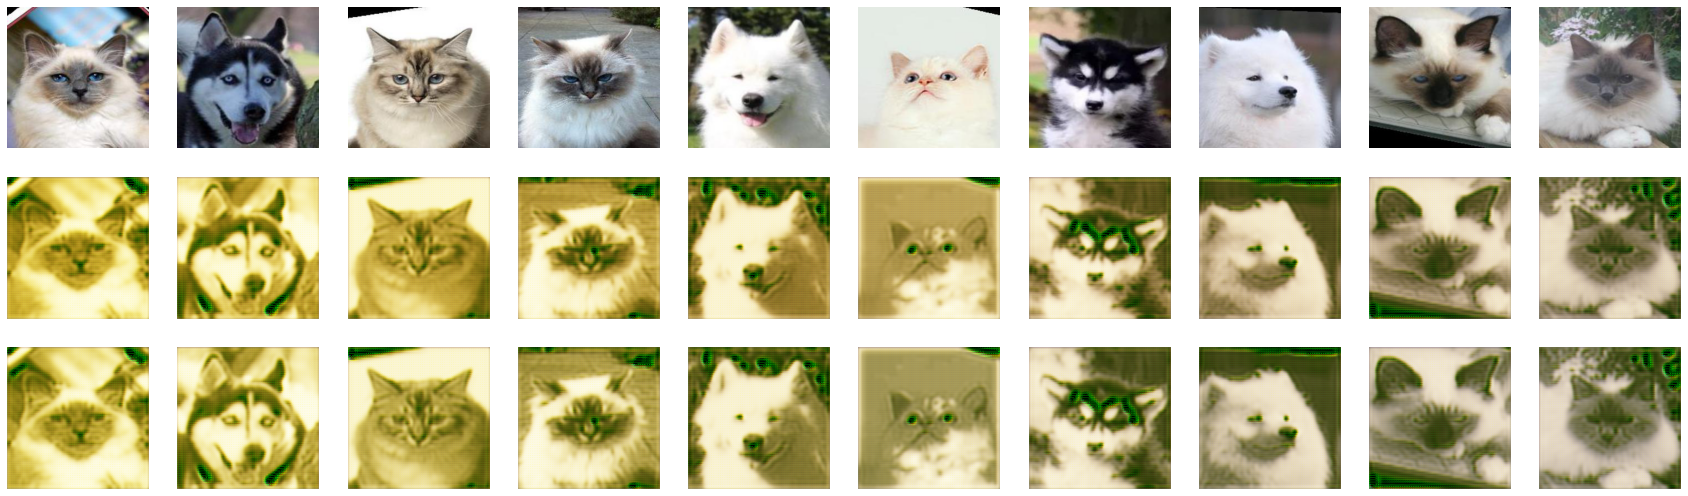

In [ ]:
def draw(z, step):
    with torch.no_grad():
        fig = plt.figure(figsize=(30, 12))
        combined.eval()
        for i, (image,y) in enumerate(test_loader):
            sample = image[0].numpy()
            sample = sample.swapaxes(0, 1)
            sample = sample.swapaxes(1, 2)
            ax = plt.subplot(4, 10, i + 1)
            ax.axis('off')
            plt.imshow(sample)
            z += step
            for cls in range(2):
              image = image.to(device)
              y = np.zeros((batch_size,y_length))
              y[:,cls] = 1
              y = torch.from_numpy(y).float()
              y = y.to(device)
              pred = combined.generate_image(image,y,z)
              image = image.cpu()
              pred = pred.cpu()
              sample = pred[0].numpy()
              sample = sample.swapaxes(0, 1)
              sample = sample.swapaxes(1, 2)
              ax = plt.subplot(4, 10, (cls+1)*10 + i + 1)
              ax.axis('off')
              plt.imshow(sample)
            if i >= 9:
                plt.show(block = False)
                plt.close()
                break 

draw(z = torch.tensor(1*np.ones((batch_size, Z_length))).float(), step = -0.1)

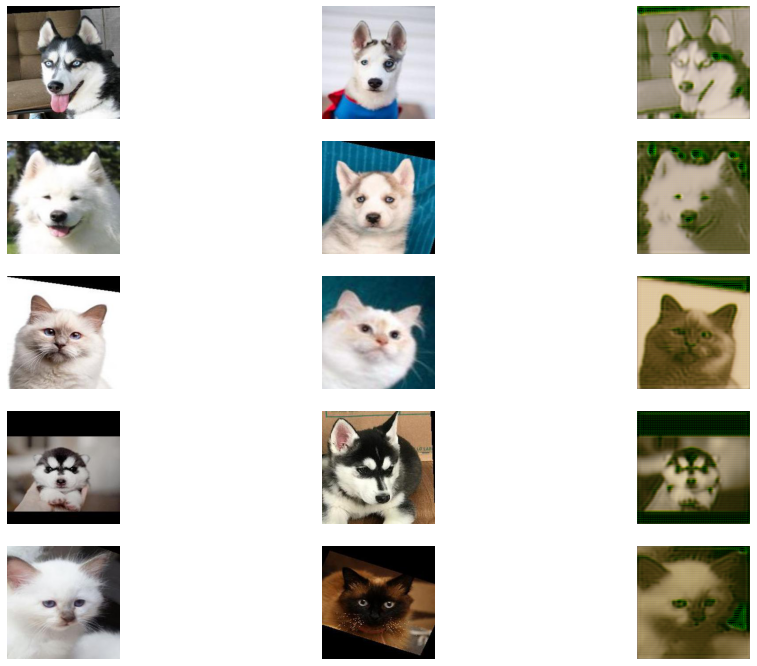

In [ ]:
def draw(combined):
    with torch.no_grad():
        fig = plt.figure(figsize=(16, 12))
        combined.eval()
        for i, (image,y) in enumerate(test_loader):
            sample = image[0].numpy()
            sample = sample.swapaxes(0, 1)
            sample = sample.swapaxes(1, 2)
            style = image[1].numpy()
            style = style.swapaxes(0, 1)
            style = style.swapaxes(1, 2)
            ax = plt.subplot(5, 3, 1 + i*3)
            ax.axis('off')
            plt.imshow(sample)
            image = image.to(device)
            image_style = image.clone()
            image_style[0] = image_style[1]
            image_style = image_style.to(device)
            y[0] = y[1]
            y = y.to(device)
            pred = combined.style_transfer(image,y, image_style)
            # style = style.cpu()
            # image = image.cpu()
            pred = pred.cpu()
            ax = plt.subplot(5, 3, 2 + i*3)
            ax.axis('off')
            plt.imshow(style)
            sample = pred[0].numpy()
            sample = sample.swapaxes(0, 1)
            sample = sample.swapaxes(1, 2)
            ax = plt.subplot(5, 3, 3 + i*3)
            ax.axis('off')
            plt.imshow(sample)
            if i >= 4:
              plt.show(block = False)
              plt.close()
              break

draw(combined)